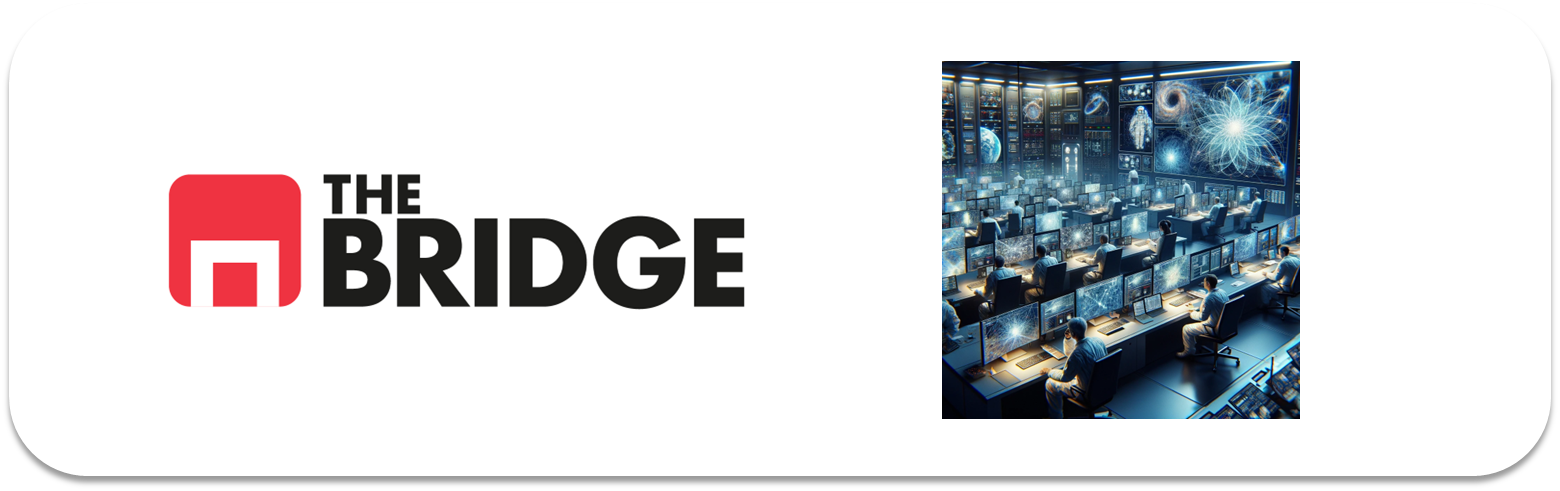

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [14]:
ROOT_PATH = './archive/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"


In [50]:
def read_data(directorio, reshape_dim = (75,75)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [51]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

In [52]:
X_train.shape

(14034, 75, 75, 3)

In [53]:
y_train.shape

(14034,)

In [54]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

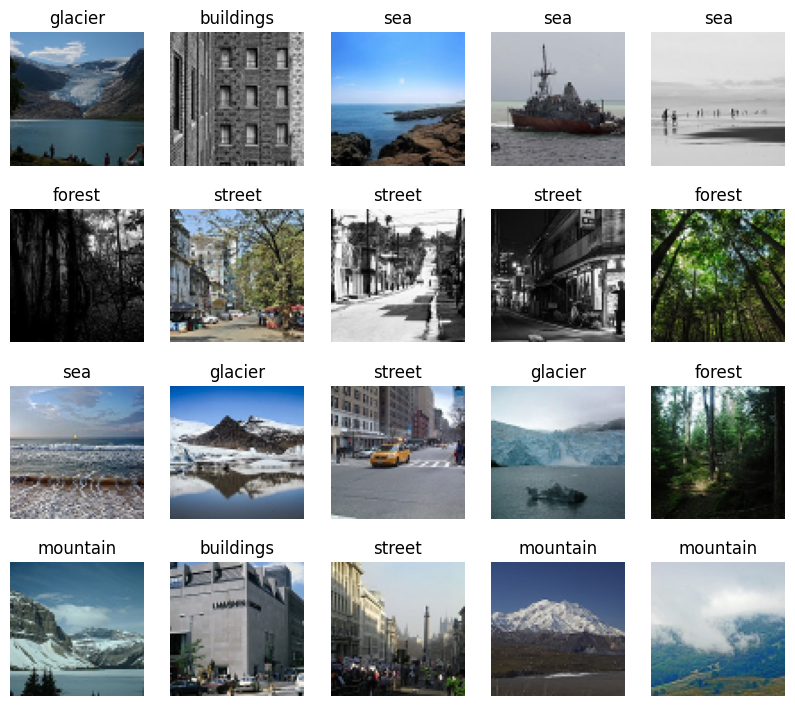

In [55]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [56]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [57]:
X_train = X_train/255
X_test = X_test/255

. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [86]:
base_model = InceptionV3(include_top=False, 
                        weights="imagenet")

In [87]:
for layer in base_model.layers:
    layer.trainable = False

In [88]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) # Capa oculta 1
x = layers.Dense(128, activation='relu')(x) # Capa oculta 2
predictions = layers.Dense(6, activation='softmax')(x) # Capa de salida

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [89]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, None, None, 32)       864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, None, None, 32)       96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, None, None, 32)       0         ['batch_normalization_37

In [62]:
y_train

array(['buildings', 'buildings', 'buildings', ..., 'street', 'street',
       'street'], dtype='<U9')

In [63]:
mapeo = {'buildings':0, 
 'forest':1, 
 'glacier':2, 
 'mountain':3, 
 'sea':4, 
 'street':5}

y_train_mapped = np.array([mapeo[label] for label in y_train])
y_test_mapped = np.array([mapeo[label] for label in y_test])

In [90]:
model.fit(X_train, y_train_mapped, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
395/395 [==============================] - 42s 98ms/step - loss: 0.7299 - accuracy: 0.7219 - val_loss: 0.8901 - val_accuracy: 0.6681
Epoch 2/10
395/395 [==============================] - 39s 98ms/step - loss: 0.4988 - accuracy: 0.8092 - val_loss: 0.9678 - val_accuracy: 0.6524
Epoch 3/10
395/395 [==============================] - 39s 98ms/step - loss: 0.3864 - accuracy: 0.8520 - val_loss: 0.7643 - val_accuracy: 0.7600
Epoch 4/10
395/395 [==============================] - 39s 98ms/step - loss: 0.2749 - accuracy: 0.8956 - val_loss: 1.7802 - val_accuracy: 0.5370
Epoch 5/10
395/395 [==============================] - 39s 98ms/step - loss: 0.1868 - accuracy: 0.9298 - val_loss: 1.2325 - val_accuracy: 0.7251
Epoch 6/10
395/395 [==============================] - 39s 98ms/step - loss: 0.1279 - accuracy: 0.9558 - val_loss: 1.5626 - val_accuracy: 0.7044
Epoch 7/10
395/395 [==============================] - 39s 98ms/step - loss: 0.0914 - accuracy: 0.9683 - val_loss: 1.7110 - val_accuracy:

In [91]:
model.evaluate(X_test, y_test_mapped)

94/94 [==============================] - 9s 91ms/step - loss: 1.3411 - accuracy: 0.7517


[1.3411086797714233, 0.7516666650772095]

In [92]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
inverse_map = {valor:clave for clave,valor in mapeo.items()}
y_test_labels = [inverse_map[y] for y in y_test_mapped]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))
print(classification_report(y_test_mapped, y_pred))

94/94 [==============================] - 10s 85ms/step
              precision    recall  f1-score   support

   buildings       0.73      0.86      0.79       437
      forest       0.89      0.96      0.92       474
     glacier       0.70      0.63      0.67       553
    mountain       0.64      0.73      0.68       525
         sea       0.74      0.72      0.73       510
      street       0.87      0.64      0.74       501

    accuracy                           0.75      3000
   macro avg       0.76      0.76      0.75      3000
weighted avg       0.76      0.75      0.75      3000

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       437
           1       0.89      0.96      0.92       474
           2       0.70      0.63      0.67       553
           3       0.64      0.73      0.68       525
           4       0.74      0.72      0.73       510
           5       0.87      0.64      0.74       501

    accuracy          

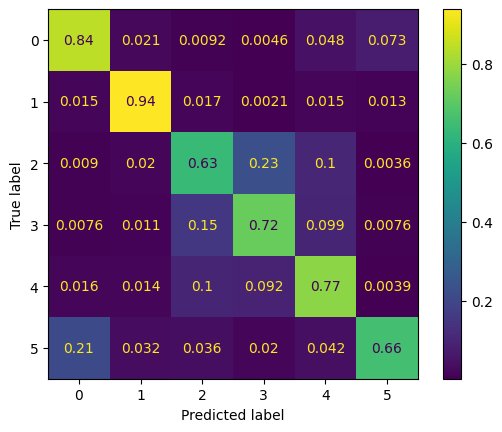

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test_mapped, y_pred, normalize="true")

In [73]:
base_model_2 = InceptionV3(include_top=False, 
                        weights= None)

In [74]:
for layer in base_model.layers:
    layer.trainable = False

In [77]:
x = base_model_2.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) # Capa oculta 1
x = layers.Dense(128, activation='relu')(x) # Capa oculta 2
predictions = layers.Dense(6, activation='softmax')(x) # Capa de salida

model_2= Model(inputs=base_model_2.input, outputs=predictions)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, None, None, 32)       96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, None, None, 32)       0         ['batch_normalization_28

In [79]:
model_2.fit(X_train, y_train_mapped, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
395/395 [==============================] - 242s 573ms/step - loss: 1.1321 - accuracy: 0.5797 - val_loss: 4.1389 - val_accuracy: 0.1332
Epoch 2/10
395/395 [==============================] - 240s 608ms/step - loss: 0.8078 - accuracy: 0.7150 - val_loss: 1.7695 - val_accuracy: 0.4886
Epoch 3/10
395/395 [==============================] - 228s 578ms/step - loss: 0.7093 - accuracy: 0.7545 - val_loss: 1.0378 - val_accuracy: 0.5328
Epoch 4/10
395/395 [==============================] - 232s 587ms/step - loss: 0.6893 - accuracy: 0.7644 - val_loss: 1.4644 - val_accuracy: 0.5021
Epoch 5/10
395/395 [==============================] - 219s 555ms/step - loss: 0.6137 - accuracy: 0.7899 - val_loss: 0.4290 - val_accuracy: 0.8540
Epoch 6/10
395/395 [==============================] - 224s 566ms/step - loss: 0.5586 - accuracy: 0.8107 - val_loss: 2.6262 - val_accuracy: 0.2472
Epoch 7/10
395/395 [==============================] - 229s 581ms/step - loss: 0.5336 - accuracy: 0.8188 - val_loss: 1.9639 -

In [80]:
model_2.evaluate(X_test, y_test_mapped)

94/94 [==============================] - 9s 93ms/step - loss: 1.5070 - accuracy: 0.5557


[1.5069580078125, 0.5556666851043701]

In [83]:
y_pred = np.argmax(model_2.predict(X_test), axis=-1)
inverse_map = {valor:clave for clave,valor in mapeo.items()}
y_test_labels = [inverse_map[y] for y in y_test_mapped]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))
print(classification_report(y_test_mapped, y_pred))

94/94 [==============================] - 8s 80ms/step
              precision    recall  f1-score   support

   buildings       0.31      0.99      0.48       437
      forest       0.98      0.37      0.54       474
     glacier       0.83      0.46      0.59       553
    mountain       0.66      0.73      0.69       525
         sea       0.82      0.64      0.72       510
      street       0.63      0.19      0.29       501

    accuracy                           0.56      3000
   macro avg       0.70      0.56      0.55      3000
weighted avg       0.71      0.56      0.55      3000

              precision    recall  f1-score   support

           0       0.31      0.99      0.48       437
           1       0.98      0.37      0.54       474
           2       0.83      0.46      0.59       553
           3       0.66      0.73      0.69       525
           4       0.82      0.64      0.72       510
           5       0.63      0.19      0.29       501

    accuracy           

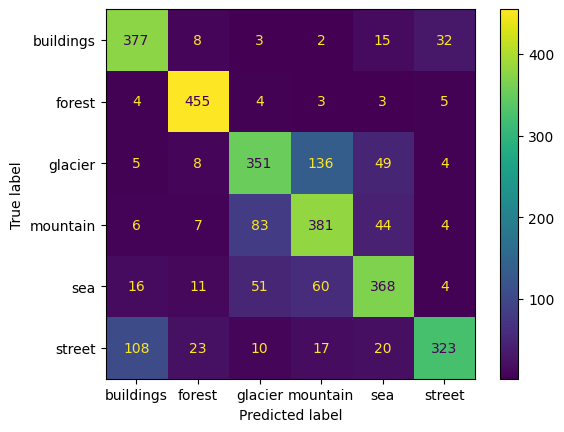

In [97]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels)